In [ ]:
!pip install -qU catboost eif shap category_encoders
from catboost import CatBoostRegressor, Pool, CatBoostClassifier, EShapCalcType, EFeaturesSelectionAlgorithm
import eif
import category_encoders as ce
import shap
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output
clear_output()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, log_loss, roc_curve, auc, accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report
from scipy import stats
import statsmodels.stats.power asimport pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, log_loss, roc_curve, auc, accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report
from scipy import stats
import statsmodels.stats.power as power
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from itertools import combinations
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from xgboost import XGBClassifier
import xgboost
from lightgbm import LGBMClassifier
import lightgbm
import tensorflow as tf power
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from itertools import combinations
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from xgboost import XGBClassifier
import xgboost
from lightgbm import LGBMClassifier
import lightgbm
import tensorflow as tf

In [ ]:
def cross_validation(clf, X, y, scoring='f1'):
    scores = cross_val_score(estimator=clf, X=X, y=y, cv=10, scoring=scoring, n_jobs=-1)
    print(f'Меры правильности перекрекстной оценки: {scores}')
    print(f'Точность перекретсной оценки: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')
    return scores

def plot_cm_val(y_true, y_pred, X, y, estimator, scoring='f1'):
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    conf_df = pd.DataFrame(cm, index=[0,1], columns=[0,1])
    scores = np.array(cross_validation(estimator, X, y, scoring=scoring))
    print('\n')
    plt.figure(figsize=(16,6))
    plt.subplot(121)
    sns.heatmap(conf_df, cmap="Oranges", annot=True, annot_kws={"size": 16}, fmt='d')
    plt.title('Confusion matrix for test')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.subplot(122)
    plt.plot(scores, c='g', linestyle=':', label='Cross Validation Scores', marker='*')
    plt.fill_between(np.arange(scores.shape[0]), scores.mean() - scores.std(), scores.mean() + scores.std(), alpha=0.3)
    plt.axhline(0.65, c='r', linestyle='--', label='min f1_score')
    plt.axhline(scores.mean(), c='b', linestyle='-.', label='score mean')
    plt.legend(loc='best')
    plt.ylim([0.6, max(scores) + 0.1])
    plt.xticks(np.arange(scores.shape[0]))
    plt.grid()
    plt.show()

def report(y_train, y_train_pred, y_test, y_test_pred):
    print('Train\n', classification_report(y_train, y_train_pred, digits=3))
    print('Test\n', classification_report(y_test, y_test_pred, digits=3))
    print('Confusion Matrix', '\n', pd.crosstab(y_test, y_test_pred))

def vote(predictions: list, weights: list):
    predictions = np.asarray(predictions).T
    maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=weights)), axis=1, arr=predictions)
    return maj_vote

def reduce_memory(df):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and str(col_type)[:4] != 'uint' and str(col_type) != 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif str(col_type)[:4] != 'uint':
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)
data_train_root = r'/content/drive/My Drive/data/insurance/train.csv'
data_test_root = r'/content/drive/My Drive/data/insurance/test.csv'
data_sub_root = r'/content/drive/My Drive/data/insurance/submission.csv'
TARGET_NAME = 'Response'

In [ ]:
train = pd.read_csv(data_train_root)
test = pd.read_csv(data_test_root)
train.set_index('Id', drop=True, inplace=True)
test.set_index('Id', drop=True, inplace=True)

In [ ]:
train.sample(5)

,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,Medical_History_2,Medical_History_3,...,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
40510,1,D4,26,0.282051,2,3,1,0.208955,0.745455,0.711297,1.000000,0.055000,9,1,0.0,2,0.00,1,2,8,3,1,1,1,2,1,1,3,NaN,3,2,3,3,0.376812,NaN,0.267606,NaN,NaN,162,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
39167,1,D4,10,0.230769,2,3,1,0.208955,0.727273,0.255230,0.390765,0.025000,9,1,0.0,3,0.30,1,2,3,3,1,2,1,1,1,3,1,0.000667,1,1,2,3,0.420290,NaN,0.394366,NaN,3.0,417,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7
34698,1,A2,26,0.487179,2,3,1,0.432836,0.654545,0.251046,0.455504,0.141000,12,1,0.3,2,1.00,2,2,3,3,1,2,1,2,1,3,1,0.001863,1,3,1,3,NaN,0.441176,NaN,0.589286,21.0,543,3,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
31,1,D2,26,0.076923,2,3,1,0.641791,0.618182,0.288703,0.571939,0.070000,1,3,0.0,2,1.00,1,2,3,3,1,2,1,1,1,3,1,0.000667,1,1,2,3,NaN,0.578431,0.676056,NaN,1.0,3,2,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
23272,1,D1,26,0.230769,2,3,1,0.238806,0.709091,0.251046,0.400535,0.080016,9,1,0.0,2,0.05,2,2,8,3,1,1,1,2,1,1,3,NaN,3,2,3,2,NaN,NaN,0.422535,NaN,8.0,16,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2


In [ ]:
print(train.duplicated().astype(int).sum(), test.duplicated().astype(int).sum())
train.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)
# check also constant variables

15 1


In [ ]:
train.describe()

,Product_Info_1,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,...,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
count,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41536.000000,41551.000000,41551.000000,36726.00000,41551.000000,34007.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,23726.000000,41551.000000,41551.000000,41551.000000,41551.000000,21418.000000,17665.000000,28130.000000,12283.000000,35399.000000,41551.000000,41551.000000,41551.000000,...,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000,41551.000000
mean,1.025559,24.408751,0.328978,2.007148,2.674617,1.042695,0.405686,0.707280,0.292591,0.469362,0.077314,8.642993,1.302135,0.00612,2.143968,0.361321,1.209839,2.007028,5.840437,2.882530,1.026714,1.410628,1.038748,1.728526,1.055763,2.144449,1.960723,0.001721,1.903901,2.048182,2.420760,2.683449,0.474155,0.497652,0.444910,0.484704,7.942993,255.038988,2.102404,1.654208,...,0.036967,0.058819,0.010301,0.005920,0.008038,0.189261,0.013020,0.009530,0.007316,0.009266,0.007870,0.014825,0.037568,0.098674,0.019518,0.088710,0.013405,0.011961,0.015138,0.011408,0.024837,0.010902,0.020649,0.023056,0.020240,0.006715,0.010541,0.066906,0.006715,0.013670,0.056485,0.010228,0.045968,0.010638,0.007389,0.014007,0.008544,0.019566,0.054872,5.632861
std,0.157817,5.085237,0.282406,0.084243,0.738177,0.288998,0.197295,0.074579,0.089400,0.122212,0.081468,4.233532,0.716238,0.03044,0.351061,0.349354,0.418622,0.083536,2.686285,0.321983,0.229600,0.491954,0.275673,0.444725,0.329233,0.989512,0.946205,0.007579,0.971845,0.754282,0.509757,0.484747,0.154516,0.140445,0.162852,0.129449,13.006936,178.762316,0.303342,0.475631,...,0.188682,0.235289,0.100969,0.076717,0.089297,0.391721,0.113362,0.097159,0.085223,0.095813,0.088363,0.120854,0.190152,0.298227,0.138339,0.284328,0.115004,0.108713,0.122103,0.106197,0.155630,0.103844,0.142209,0.150083,0.140823,0.081668,0.102129,0.249862,0.081668,0.116118,0.230858,0.100618,0.209417,0.102590,0.085639,0.117520,0.092038,0.138506,0.227734,2.456291
min,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.058577,0.058838,0.000000,1.000000,1.00000

In [ ]:
train.describe(include=np.object)

,Product_Info_2
count,41551
unique,19
top,D3
freq,10053


In [ ]:
train[TARGET_NAME].value_counts(normalize=True)  # classes are imbalanced

8    0.326587
6    0.190248
7    0.135905
2    0.111453
1    0.104089
5    0.090395
4    0.024404
3    0.016919
Name: Response, dtype: float64

In [ ]:
for i in range(0, train.shape[1], 30):
    print(train.iloc[:, i:i+30].info())

In [ ]:
# define groups of columns to further separate analisys
group_st_names = ['Product_Info', 'Employment_Info', 'InsuredInfo', 'Insurance_History', 
                  'Family_Hist', 'Medical_History']
groups_dict = {}
for col_start in group_st_names:
    ls = []
    for column in train.columns.to_list():
        if column.startswith(col_start):
            ls.append(column)
    groups_dict[col_start] = ls

In [ ]:
# value counts: seems like almost all variables are categorical, some of them were already been encoded
# we can treat them as numerical as well, but also we may try to encode vars that were not encoded
for x in groups_dict.get('Medical_History'):
    print(train[x].value_counts())

In [ ]:
# missing data percentage
columns_to_drop = []
for column in train.columns:
    per = 100 * train[column].isna().sum() / train.shape[0]
    if per != 0:
        print(f'{column}: {per:.2f}% missing,', 'to drop or add new category' if per >=50 else 'try to impute or predict')
        if per >= 50:
            columns_to_drop.append(column)

Employment_Info_1: 0.04% missing, try to impute or predict
Employment_Info_6: 18.16% missing, try to impute or predict
Family_Hist_4: 32.30% missing, try to impute or predict
Medical_History_1: 14.81% missing, try to impute or predict


In [ ]:
for x in columns_to_drop:
    print(train[x].value_counts())
# all columns to drop are numerical or encoded like numerical

In [ ]:
# instead of boxplots
def check_iqr(factor: np.ndarray):
    q1 = np.quantile(factor, 0.25)
    q3 = np.quantile(factor, 0.75)
    iqr = q3 - q1
    upper_bound, lower_bound = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return upper_bound, lower_bound

for column in train.select_dtypes(exclude=np.object).drop(TARGET_NAME, axis=1).columns[:-48]:
    upper_bound, lower_bound = check_iqr(train[column].values)
    upper = train[train[column] > upper_bound].shape[0]
    lower = train[train[column] < lower_bound].shape[0]
    if lower > 0 or upper > 0:
        print(f'{column} has {upper} upper, {lower} lower possible outliers')

In [ ]:
train.drop(columns_to_drop, axis=1, inplace=True)

In [ ]:
# replace or drop outliers: only extreme outliers, as there are too many outliers according to iqr test
iso = IsolationForest(n_estimators=100, contamination=0.0005, random_state=1)
learn = train[['Product_Info_4']].fillna(method='ffill').values
iso.fit(learn.reshape(-1,1))
outliers = iso.predict(learn)

In [ ]:
train.loc[outliers == -1, groups_dict.get('Product_Info')]

,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7
Id,,,,,,,
3419,1,D4,10,0.834308,2,3,1
7948,1,D1,26,0.831795,2,3,1
12271,1,E1,26,0.834530,2,3,1
20812,1,D4,26,0.876923,2,3,1


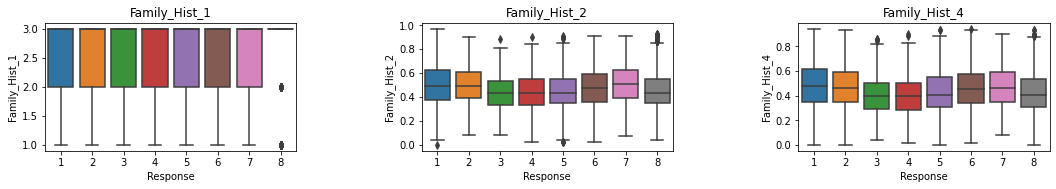

In [ ]:
plt.figure(figsize=(18,20))
for i, column in enumerate(train[groups_dict.get('Family_Hist')].columns, 1):
    plt.subplot(6,3, i)
    sns.boxplot(y=train[column], x=train[TARGET_NAME], data=train)
    plt.title(f'{column}')
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

In [ ]:
# assume outliers present only in Medical_Info_1, drop >= 175 in preprocessor

,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7
Id,,,,,,,
1,1,D3,10,0.076923,2,1,1
2,1,E1,26,0.076923,2,3,1
3,1,D4,10,0.487179,2,3,1
4,1,D2,26,0.230769,2,3,1
5,1,D2,26,0.230769,3,1,1


In [ ]:
X, y = train.drop(TARGET_NAME, axis=1), train[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=1)
X_train = reduce_memory(X_train)
X_test = reduce_memory(X_test)
enc = ce.CatBoostEncoder(random_state=1)
X_train = enc.fit_transform(X_train, y_train)
X_test = enc.transform(X_test)
imp = IterativeImputer(random_state=1)
X_train = imp.fit_transform(X_train)
X_test = imp.transform(X_test)

Memory usage of dataframe is 26.85 MB
Memory usage after optimization is: 4.58 MB
Decreased by 83.0%
Memory usage of dataframe is 11.51 MB
Memory usage after optimization is: 1.96 MB
Decreased by 82.9%


In [ ]:
# no scaling for start
base_lr_pipeline = make_pipeline(#IterativeImputer(random_state=1),
                                 LogisticRegression(random_state=1, ))
base_lr_pipeline.fit(X_train, y_train)
y_train_pred = base_lr_pipeline.predict(X_train)
y_test_pred = base_lr_pipeline.predict(X_test)
report(y_train, y_train_pred, y_test, y_test_pred)

Train
               precision    recall  f1-score   support

           1      0.276     0.210     0.238      3027
           2      0.000     0.000     0.000      3242
           3      0.000     0.000     0.000       492
           4      0.000     0.000     0.000       710
           5      0.000     0.000     0.000      2629
           6      0.250     0.148     0.186      5533
           7      0.500     0.001     0.002      3953
           8      0.387     0.957     0.551      9499

    accuracy                          0.363     29085
   macro avg      0.177     0.164     0.122     29085
weighted avg      0.271     0.363     0.240     29085

Test
               precision    recall  f1-score   support

           1      0.272     0.203     0.233      1298
           2      0.000     0.000     0.000      1389
           3      0.000     0.000     0.000       211
           4      0.000     0.000     0.000       304
           5      0.000     0.000     0.000      1127
           

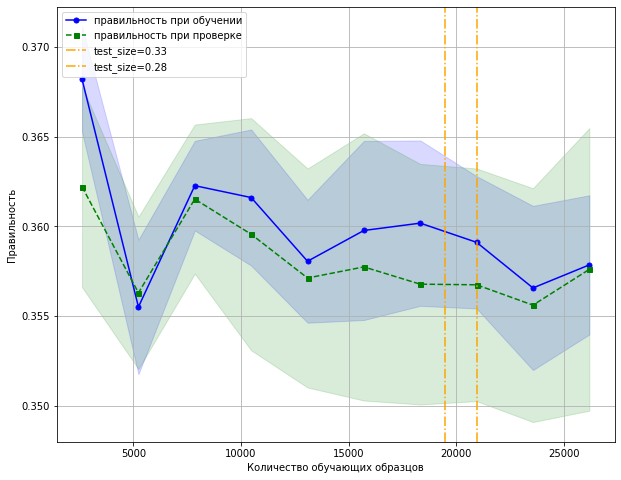

In [ ]:
# the result is very approximated
estimator = make_pipeline(LogisticRegression(random_state=1))
train_sizes, train_scores, test_scores = learning_curve(estimator=estimator, X=X_train, y=y_train, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10), cv=10, scoring='accuracy', n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(10, 8))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='правильность при обучении')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, 
         label='правильность при проверке')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.axvline(X_train.shape[0]*0.67, color='orange', linestyle='-.', label='test_size=0.33')
plt.axvline(X_train.shape[0]*0.72, color='orange', linestyle='-.', label='test_size=0.28')
plt.grid()
plt.xlabel('Количество обучающих образцов')
plt.ylabel('Правильность')
plt.legend(loc='best')
plt.show()

In [ ]:
def effect_size(factor_a, factor_b, cohen=True, desired_power=0.8, alpha=0.05):
    n1, n2 = len(factor_a), len(factor_b)
    s1, s2 = factor_a.std(ddof=1), factor_b.std(ddof=1)
    df = (s1 ** 2 / n1 + s2 ** 2 / n2) ** 2 / \
          ((s1 ** 2 / n1) ** 2 / (n1 - 1) + (s2 ** 2 / n2) ** 2 / (n2 - 1))
    if cohen:
        sigma_pooled = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
        return np.abs(factor_a.mean() - factor_b.mean()) / sigma_pooled, df
    else:
        return power.tt_ind_solve_power(effect_size=None, nobs1=len(factor_a), alpha=alpha, power=desired_power,
                                        ratio=len(factor_b)/len(factor_a), alternative='two-sided'), df

# better take f_oneway as we are solving multi-label classification task
# one factor for one label in feature, anova takes multiple factors as argument
def statistic_output(*columns, df=train, cat=False, target=TARGET_NAME, alpha=0.05, sample_size=0):
    data = df.copy()
    labels = data[target].unique().tolist()
    data.drop_duplicates(inplace=True)
    if sample_size == 0:
        sample_size = int(0.05 * len(data))
    if not cat:
        # columns = data.drop(target, axis=1).select_dtypes(exclude=['category', np.object]).columns
        for column in columns:
            result_mask = np.array([])
            df_sampled = data[[column, target]].sample(sample_size, random_state=1)
            _, pvalue = stats.shapiro(df_sampled[column])
            is_normal = pvalue >= alpha
            eff_pow_list = []
            for label in combinations(labels, r=2):
                label1, label2 = label
                if label1 == label2: continue
                factor_a = df_sampled.loc[df_sampled[target] == label1][column]   
                factor_b = df_sampled.loc[df_sampled[target] == label2][column]  
                if is_normal:
                    _, pvalue = stats.ttest_ind(factor_a, factor_b, equal_var=False)
                    test = power.TTestIndPower()
                    eff_size, deg_free = effect_size(factor_a, factor_b, cohen=False)
                    pow = test.power(effect_size=eff_size, nobs1=len(factor_a), alpha=alpha, df=deg_free, 
                                     ratio=len(factor_b)/len(factor_a), alternative='two-sided')
                    eff_pow_list.append((f'{eff_size:4f}', f'{100*pow:2f}'))
                else:
                    try:
                        _, pvalue = stats.mannwhitneyu(factor_a, factor_b)
                    except ValueError:
                        continue
                if pvalue < alpha:
                    result_mask = np.append(result_mask, 1)
                else:
                    result_mask = np.append(result_mask, 0)
            if np.any(result_mask):
                print(f'Factor "{column}" has statistical influence on target. {eff_pow_list}')
            else:
                print(f'Factor "{column}" does not affect target.')
    else:
        for column in columns:
            print(column)
            data.reset_index(inplace=True)
            data = data.rename(columns={'index': 'Id'})
            categories = data[column].unique().tolist()
            result = np.array([])
            for pair in combinations(categories, r=2):
                a, b = pair
                if a == b: continue
                for label in combinations(labels, r=2):
                    if label[0] == label[1]: continue
                    condition = ((data[column].isin(pair)) & (data[target].isin(label)))
                    try:
                        data_ = data.loc[condition, ['Id', column, target]].sample(sample_size, random_state=1)
                    except ValueError:
                        result = np.append(result, 0)
                        break
                    table = data_.pivot_table(values='Id', index=column, columns=target, aggfunc='count')
                    _, pvalue, _, _ = stats.chi2_contingency(table, correction=False)
                    if pvalue >= alpha:
                        result = np.append(result, 1)
                    else:
                        result = np.append(result, 0)
                if np.all(result):
                    print(f'Categories {a} and {b} can be united.')
                else:
                    print(f'Categories {a} and {b} have different frequencies with target.')

def correlation(df: pd.DataFrame, target=TARGET_NAME, alpha=0.05, threshold=0.66):
    data = df.copy()
    data = data.drop(target, axis=1)
    columns = data.select_dtypes(exclude=['category', np.object]).columns
    for pair in combinations(columns, r=2):
        col1, col2 = pair
        r = np.corrcoef(data[col1], data[col2])[0,1]
        if r >= threshold:
            n = len(data[col1])
            t = r * np.sqrt(n - 2) / np.sqrt(1 - r ** 2)
            p_left = stats.t.cdf(t, df=n)  # also may calculate quantiles by ppf and compare with t
            p_right = 1 - stats.t.cdf(t, df=n)
            pvalue = 2 * min(p_left, p_right)
            if pvalue < alpha:
                print(f'Correlation between {col1} and {col2} is statisticaly strong: {r:.4f}.')
            else:
                print(f'Correlation between {col1} and {col2} is high but not statisticaly meaningful.')

In [ ]:
X_stat = pd.DataFrame(np.hstack((X_train, y_train.values.reshape(-1,1))), columns=train.columns.to_list())

In [ ]:
statistic_output(*X_stat.drop(TARGET_NAME, axis=1).columns.to_list()[:-48], df=X_stat)
# candidates to drop

Factor "Product_Info_1" does not affect target.
Factor "Product_Info_2" has statistical influence on target. []
Factor "Product_Info_3" has statistical influence on target. []
Factor "Product_Info_4" has statistical influence on target. []
Factor "Product_Info_5" has statistical influence on target. []
Factor "Product_Info_6" has statistical influence on target. []
Factor "Product_Info_7" does not affect target.
Factor "Ins_Age" has statistical influence on target. []
Factor "Ht" has statistical influence on target. []
Factor "Wt" has statistical influence on target. []
Factor "BMI" has statistical influence on target. []
Factor "Employment_Info_1" has statistical influence on target. []
Factor "Employment_Info_2" has statistical influence on target. []
Factor "Employment_Info_3" has statistical influence on target. []
Factor "Employment_Info_4" has statistical influence on target. []
Factor "Employment_Info_5" has statistical influence on target. []
Factor "Employment_Info_6" has stat

In [ ]:
statistic_output('Product_Info_5', df=X_stat, cat=True, sample_size=100)
# no signs to union categories

Product_Info_5
Categories 2.0 and 3.0 have different frequencies with target.


In [ ]:
correlation(X_stat)  # candidates to drop

Correlation between Ins_Age and Family_Hist_2 is statisticaly strong: 0.9227.
Correlation between Ins_Age and Family_Hist_4 is statisticaly strong: 0.9324.
Correlation between Wt and BMI is statisticaly strong: 0.8540.
Correlation between Insurance_History_1 and Insurance_History_8 is statisticaly strong: 0.7879.
Correlation between Insurance_History_4 and Insurance_History_7 is statisticaly strong: 0.9206.
Correlation between Insurance_History_4 and Insurance_History_9 is statisticaly strong: 0.9391.
Correlation between Insurance_History_7 and Insurance_History_9 is statisticaly strong: 0.9632.
Correlation between Family_Hist_2 and Family_Hist_4 is statisticaly strong: 0.9791.
Correlation between Medical_History_19 and Medical_Keyword_30 is statisticaly strong: 0.8385.
Correlation between Medical_History_25 and Medical_History_36 is statisticaly strong: 0.9546.


In [ ]:
stats_cols_to_drop = ['Family_Hist_2', 'Family_Hist_4', 'Medical_Keyword_30', 'Medical_History_36', 'Medical_History_35', 
                      'Medical_History_22', 'InsuredInfo_3', 'Product_Info_7', 'Product_Info_1',
                      'Medical_Keyword_30', 'Insurance_History_9', 'Insurance_History_7',
                      'Insurance_History_8', 'Wt']
# alt: 'Family_Hist_2', 'Family_Hist_4', 'Wt' / 'Ins_Age', 'BMI'

In [ ]:
X_stat[['BMI', 'Ht']].corr(method='kendall')

,BMI,Ht
BMI,1.000000,0.117725
Ht,0.117725,1.000000


In [ ]:
tsne_pipeline = make_pipeline(MinMaxScaler(), 
                              TSNE(n_components=2, random_state=1, n_jobs=-1))
medical_hist = tsne_pipeline.fit_transform(X_stat[groups_dict.get('Medical_History')])

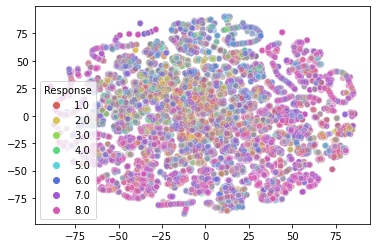

In [ ]:
sns.scatterplot(x=medical_hist[:,0], y=medical_hist[:,1],
    hue=TARGET_NAME,
    palette=sns.color_palette("hls", 8),
    data=X_stat,
    legend="full",
    alpha=0.3)
plt.show()

In [ ]:
#drop_indices = [i for i, col in enumerate(train.columns) if col not in stats_cols_to_drop]
drop_indices = [i for i, col in enumerate(train.columns) if col not in stats_cols_to_drop or col not in to_drop_var]

In [ ]:
lr_with_scale = make_pipeline(MinMaxScaler(),
                              LogisticRegression(solver='saga', penalty='elasticnet', C=10., l1_ratio=0.7,
                                                 class_weight='balanced', random_state=1))
lr_with_scale.fit(X_train[:, drop_indices[:-1]], y_train)
y_train_pred = lr_with_scale.predict(X_train[:, drop_indices[:-1]])
y_test_pred = lr_with_scale.predict(X_test[:, drop_indices[:-1]])
report(y_train, y_train_pred, y_test, y_test_pred)

Train
               precision    recall  f1-score   support

           1      0.326     0.334     0.330      3027
           2      0.349     0.260     0.298      3242
           3      0.130     0.427     0.199       492
           4      0.140     0.621     0.229       710
           5      0.321     0.378     0.347      2629
           6      0.398     0.190     0.257      5533
           7      0.376     0.355     0.365      3953
           8      0.717     0.704     0.711      9499

    accuracy                          0.435     29085
   macro avg      0.345     0.409     0.342     29085
weighted avg      0.469     0.435     0.439     29085

Test
               precision    recall  f1-score   support

           1      0.306     0.323     0.314      1298
           2      0.329     0.233     0.273      1389
           3      0.114     0.374     0.174       211
           4      0.132     0.602     0.216       304
           5      0.299     0.360     0.326      1127
           

In [ ]:
# PCA, VarianceThresHold, AEnc

In [ ]:
from sklearn.feature_selection import VarianceThreshold

variance_pipeline = make_pipeline(MinMaxScaler(),
                                  VarianceThreshold())
X_t = variance_pipeline.fit_transform(X_train)
indices = np.argsort(variance_pipeline[1].variances_)[::-1]
train.drop(TARGET_NAME, axis=1).columns[indices][-10:]
# candidates to drop

Index(['Medical_Keyword_13', 'Ht', 'Medical_History_17', 'Medical_History_38',
       'Medical_History_1', 'Medical_History_11', 'Medical_History_5',
       'Medical_History_35', 'Employment_Info_4', 'Insurance_History_5'],
      dtype='object')

In [ ]:
to_drop_var = ['Medical_Keyword_13', 'Ht', 'Medical_History_17', 'Medical_History_38',
       'Medical_History_1', 'Medical_History_11', 'Medical_History_5',
       'Medical_History_35', 'Employment_Info_4', 'Insurance_History_5']

In [ ]:
drop_indices = [i for i, col in enumerate(train.columns) if col not in stats_cols_to_drop or col not in to_drop_var]

In [ ]:
from sklearn.decomposition import PCA

pca_cols = groups_dict.get('Medical_History')
pca_indices = [i for i, col in enumerate(train.columns[:-1]) if col in pca_cols]

n_components = [5, 10, 15, 20, 30, 35]
exp_variance = []

for n in n_components:
    pca_pipeline = make_pipeline(MinMaxScaler(), 
                                 PCA(n_components=n, random_state=1))
    pca_pipeline.fit(X_train[:, pca_indices])
    exp_variance.append(pca_pipeline[1].explained_variance_ratio_)

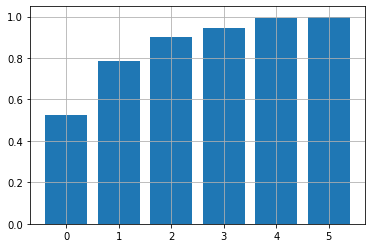

In [ ]:
expl = [x.sum() for x in exp_variance]
plt.bar(range(len(n_components)), expl)
plt.grid()
plt.show()

In [ ]:
X_train_pca = X_train.copy()
X_test_pca = X_test.copy()
pca_pipeline = make_pipeline(MinMaxScaler(), 
                             PCA(n_components=30, random_state=1))
X_train_pca_ = pca_pipeline.fit_transform(X_train_pca[:, pca_indices])
X_test_pca_ = pca_pipeline.transform(X_test_pca[:, pca_indices])

In [ ]:
X_train_pca = np.hstack((X_train[:, :36], X_train_pca_, X_train[:, 71:]))
X_test_pca = np.hstack((X_test[:, :36], X_test_pca_, X_test[:, 71:]))

In [ ]:
lr_with_scale_pca = make_pipeline(MinMaxScaler(),
                              LogisticRegression(solver='saga', penalty='elasticnet', C=10., l1_ratio=0.7,
                                                 class_weight='balanced', random_state=1))
lr_with_scale_pca.fit(X_train_pca, y_train)
y_train_pred = lr_with_scale_pca.predict(X_train_pca)
y_test_pred = lr_with_scale_pca.predict(X_test_pca)
report(y_train, y_train_pred, y_test, y_test_pred)

Train
               precision    recall  f1-score   support

           1      0.333     0.316     0.324      3027
           2      0.342     0.225     0.272      3242
           3      0.112     0.577     0.188       492
           4      0.133     0.624     0.219       710
           5      0.306     0.379     0.339      2629
           6      0.402     0.140     0.207      5533
           7      0.373     0.357     0.365      3953
           8      0.719     0.699     0.709      9499

    accuracy                          0.421     29085
   macro avg      0.340     0.415     0.328     29085
weighted avg      0.467     0.421     0.424     29085

Test
               precision    recall  f1-score   support

           1      0.310     0.301     0.306      1298
           2      0.337     0.217     0.264      1389
           3      0.101     0.517     0.169       211
           4      0.120     0.572     0.198       304
           5      0.298     0.374     0.331      1127
           

In [ ]:
from imblearn.pipeline import make_pipeline as pl

sampler_pipeline = pl(#RandomUnderSampler(sampling_strategy='auto', random_state=1),
                      SMOTE(sampling_strategy='auto', n_jobs=-1, random_state=1),)
X_train_sam, y_train_sam = sampler_pipeline.fit_resample(X_train, y_train)

lr_with_scale_pca = make_pipeline(MinMaxScaler(),
                                  LogisticRegression(solver='saga', penalty='elasticnet', C=10., l1_ratio=0.7,
                                                 class_weight='balanced', random_state=1))
lr_with_scale_pca.fit(X_train_sam[:, drop_indices[:-1]], y_train_sam)
y_train_pred = lr_with_scale_pca.predict(X_train_sam[:, drop_indices[:-1]])
y_test_pred = lr_with_scale_pca.predict(X_test[:, drop_indices[:-1]])
report(y_train_sam, y_train_pred, y_test, y_test_pred)

Train
               precision    recall  f1-score   support

           1      0.413     0.345     0.376      9499
           2      0.406     0.277     0.329      9499
           3      0.506     0.634     0.563      9499
           4      0.524     0.675     0.590      9499
           5      0.429     0.443     0.436      9499
           6      0.308     0.186     0.232      9499
           7      0.448     0.420     0.434      9499
           8      0.507     0.693     0.586      9499

    accuracy                          0.459     75992
   macro avg      0.443     0.459     0.443     75992
weighted avg      0.443     0.459     0.443     75992

Test
               precision    recall  f1-score   support

           1      0.306     0.302     0.304      1298
           2      0.321     0.220     0.261      1389
           3      0.099     0.502     0.165       211
           4      0.129     0.562     0.209       304
           5      0.293     0.371     0.327      1127
           

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda_cols = groups_dict.get('Medical_History')
lda_indices = [i for i, col in enumerate(train.columns[:-1]) if col in lda_cols]

n_components = [4, 5, 7]
exp_variance = []

for n in n_components:
    lda_pipeline = make_pipeline(MinMaxScaler(), 
                                 LDA(n_components=n))
    lda_pipeline.fit(X_train[:, lda_indices], y_train)
    exp_variance.append(lda_pipeline[1].explained_variance_ratio_)

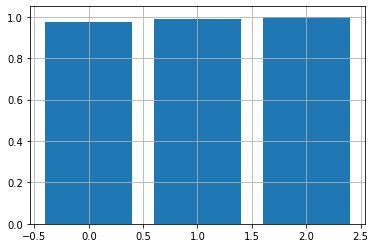

In [ ]:
expl = [x.sum() for x in exp_variance]
plt.bar(range(len(n_components)), expl)
plt.grid()
plt.show()

In [ ]:
X_train_lda = X_train.copy()
X_test_lda = X_test.copy()
lda_pipeline = make_pipeline(MinMaxScaler(), 
                             LDA(n_components=5))
X_train_lda_ = lda_pipeline.fit_transform(X_train_lda[:, lda_indices], y_train)
X_test_lda_ = lda_pipeline.transform(X_test_lda[:, lda_indices])

In [ ]:
X_train_lda = np.hstack((X_train[:, :36], X_train_lda_, X_train[:, 71:]))
X_test_lda = np.hstack((X_test[:, :36], X_test_lda_, X_test[:, 71:]))

In [ ]:
lr_with_scale_lda = make_pipeline(MinMaxScaler(),
                                  LogisticRegression(solver='saga', penalty='elasticnet', C=10., l1_ratio=0.7,
                                                     class_weight='balanced', random_state=1))
lr_with_scale_lda.fit(X_train_lda, y_train)
y_train_pred = lr_with_scale_lda.predict(X_train_lda)
y_test_pred = lr_with_scale_lda.predict(X_test_lda)
report(y_train, y_train_pred, y_test, y_test_pred)
# small improvement

Train
               precision    recall  f1-score   support

           1      0.332     0.312     0.322      3027
           2      0.359     0.243     0.290      3242
           3      0.108     0.553     0.181       492
           4      0.130     0.607     0.214       710
           5      0.308     0.372     0.337      2629
           6      0.392     0.142     0.208      5533
           7      0.370     0.351     0.360      3953
           8      0.716     0.701     0.708      9499

    accuracy                          0.421     29085
   macro avg      0.339     0.410     0.327     29085
weighted avg      0.466     0.421     0.424     29085

Test
               precision    recall  f1-score   support

           1      0.322     0.312     0.317      1298
           2      0.334     0.223     0.267      1389
           3      0.102     0.517     0.171       211
           4      0.124     0.586     0.204       304
           5      0.296     0.368     0.328      1127
           

In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential, Model

class AutoEncoder(Model): # vanilla autoencoder
    def __init__(self, output_units, reduce_units):
        super().__init__()
        self.encoder = Sequential([
                                   Dense(64, activation='relu'),
                                   Dense(32, activation='relu'),
                                   Dense(reduce_units, activation='relu')
        ])
        self.decoder = Sequential([
                                   Dense(32, activation='relu'),
                                   Dense(64, activation='relu'),
                                   Dense(output_units, activation='sigmoid')
        ])
    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

size = 25
output = 37
cols = groups_dict.get('Medical_History')
idxs = [i for i, col in enumerate(train.columns[:-1]) if col in cols]
enc = AutoEncoder(output, size)
scaler = MinMaxScaler()
X_train_scaled, X_test_scaled = scaler.fit_transform(X_train[:, idxs]), scaler.transform(X_test[:, idxs])

enc.compile(loss='mae', metrics=['mae'], optimizer=tf.keras.optimizers.Adam(lr=1e-3))
history = enc.fit(X_train_scaled, X_train_scaled, epochs=30, batch_size=32, 
                  validation_data=(X_test_scaled, X_test_scaled), 
                  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, mode='auto'),
                             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)])
                            # see email, weather, ... restore_best_weights
encoder_layer = enc.encoder
X_train_enc_ = encoder_layer.predict(X_train_scaled)
X_test_enc_ = encoder_layer.predict(X_test_scaled)

Epoch 1/30
909/909 [==============================] - 4s 4ms/step - loss: 0.0845 - mae: 0.0845 - val_loss: 0.0733 - val_mae: 0.0733 - lr: 0.0010
Epoch 2/30
909/909 [==============================] - 3s 3ms/step - loss: 0.0715 - mae: 0.0715 - val_loss: 0.0697 - val_mae: 0.0697 - lr: 0.0010
Epoch 3/30
909/909 [==============================] - 3s 3ms/step - loss: 0.0683 - mae: 0.0683 - val_loss: 0.0679 - val_mae: 0.0679 - lr: 0.0010
Epoch 4/30
909/909 [==============================] - 3s 3ms/step - loss: 0.0657 - mae: 0.0657 - val_loss: 0.0652 - val_mae: 0.0652 - lr: 0.0010
Epoch 5/30
909/909 [==============================] - 3s 3ms/step - loss: 0.0649 - mae: 0.0649 - val_loss: 0.0654 - val_mae: 0.0654 - lr: 0.0010
Epoch 6/30
909/909 [==============================] - 3s 3ms/step - loss: 0.0648 - mae: 0.0648 - val_loss: 0.0648 - val_mae: 0.0648 - lr: 0.0010
Epoch 7/30
909/909 [==============================] - 3s 3ms/step - loss: 0.0647 - mae: 0.0647 - val_loss: 0.0645 - val_mae: 0.064

In [ ]:
idxs # [35, 71]

In [ ]:
X_train_enc = np.hstack((X_train[:, :36], X_train_enc_, X_train[:, 71:]))
X_test_enc = np.hstack((X_test[:, :36], X_test_enc_, X_test[:, 71:]))

In [ ]:
lr_with_enc = make_pipeline(MinMaxScaler(),
                            LogisticRegression(solver='saga', penalty='elasticnet', C=10., l1_ratio=0.7,
                                                     class_weight='balanced', random_state=1))
lr_with_enc.fit(X_train_enc, y_train)
y_train_pred = lr_with_enc.predict(X_train_enc)
y_test_pred = lr_with_enc.predict(X_test_enc)
report(y_train, y_train_pred, y_test, y_test_pred)

Train
               precision    recall  f1-score   support

           1      0.304     0.317     0.311      3027
           2      0.324     0.205     0.251      3242
           3      0.072     0.354     0.120       492
           4      0.078     0.408     0.131       710
           5      0.316     0.364     0.338      2629
           6      0.347     0.154     0.213      5533
           7      0.348     0.325     0.336      3953
           8      0.686     0.620     0.651      9499

    accuracy                          0.380     29085
   macro avg      0.310     0.343     0.294     29085
weighted avg      0.437     0.380     0.395     29085

Test
               precision    recall  f1-score   support

           1      0.282     0.293     0.287      1298
           2      0.319     0.201     0.247      1389
           3      0.075     0.389     0.126       211
           4      0.058     0.326     0.098       304
           5      0.308     0.340     0.323      1127
           

In [ ]:
# cat shap values / categorical?
X, y = train.drop(TARGET_NAME, axis=1), train[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=1)
X_train = reduce_memory(X_train)
X_test = reduce_memory(X_test)

Memory usage of dataframe is 26.85 MB
Memory usage after optimization is: 4.58 MB
Decreased by 83.0%
Memory usage of dataframe is 11.51 MB
Memory usage after optimization is: 1.96 MB
Decreased by 82.9%


In [ ]:
alt_col_names = X_train.select_dtypes(include=['category', np.int16, np.int8]).columns.to_list()

In [ ]:
feature_names = list(X_train.columns)
cat_features = X_train.select_dtypes(include='category').columns.to_list()
cat_indices = [i for i, col in enumerate(X.columns) if col in cat_features]

train_pool = Pool(X_train, y_train, feature_names=feature_names, cat_features=cat_features)
test_pool = Pool(X_test, y_test, feature_names=feature_names, cat_features=cat_features)

def select_features(algorithm: EFeaturesSelectionAlgorithm, steps: int = 1):
    print('Algorithm:', algorithm)
    model = CatBoostClassifier(iterations=100, random_seed=0)
    summary = model.select_features(
        train_pool,
        eval_set=test_pool,
        features_for_select=list(range(train_pool.num_col())),
        num_features_to_select=int(X_train.shape[1]*0.9),
        steps=steps,
        algorithm=algorithm,
        shap_calc_type=EShapCalcType.Regular,
        train_final_model=False,
        logging_level='Silent',
        plot=False
    )
    print('Selected features:', summary['selected_features_names'])
    return summary

feature_set = select_features(algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, steps=3)

Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues
Selected features: ['Product_Info_1', 'Product_Info_2', 'Product_Info_3', 'Product_Info_4', 'Product_Info_5', 'Product_Info_6', 'Product_Info_7', 'Ins_Age', 'Wt', 'BMI', 'Employment_Info_1', 'Employment_Info_2', 'Employment_Info_3', 'Employment_Info_4', 'Employment_Info_5', 'InsuredInfo_1', 'InsuredInfo_2', 'InsuredInfo_3', 'InsuredInfo_4', 'InsuredInfo_5', 'InsuredInfo_6', 'InsuredInfo_7', 'Insurance_History_1', 'Insurance_History_2', 'Insurance_History_3', 'Insurance_History_4', 'Insurance_History_7', 'Insurance_History_8', 'Insurance_History_9', 'Family_Hist_1', 'Family_Hist_2', 'Family_Hist_4', 'Medical_History_1', 'Medical_History_3', 'Medical_History_4', 'Medical_History_5', 'Medical_History_6', 'Medical_History_7', 'Medical_History_8', 'Medical_History_9', 'Medical_History_11', 'Medical_History_13', 'Medical_History_14', 'Medical_History_16', 'Medical_History_17', 'Medical_History_18', 'Medical_History_19', 'Medical_Hi

In [ ]:
features_to_drop_set = set(feature_set['eliminated_features_names'] + stats_cols_to_drop + to_drop_var)
features_to_drop_set

{'Employment_Info_4',
 'Employment_Info_6',
 'Family_Hist_2',
 'Family_Hist_4',
 'Ht',
 'Insurance_History_5',
 'Insurance_History_7',
 'Insurance_History_8',
 'Insurance_History_9',
 'InsuredInfo_3',
 'Medical_History_1',
 'Medical_History_11',
 'Medical_History_12',
 'Medical_History_17',
 'Medical_History_2',
 'Medical_History_22',
 'Medical_History_29',
 'Medical_History_34',
 'Medical_History_35',
 'Medical_History_36',
 'Medical_History_38',
 'Medical_History_5',
 'Medical_Keyword_1',
 'Medical_Keyword_11',
 'Medical_Keyword_13',
 'Medical_Keyword_2',
 'Medical_Keyword_22',
 'Medical_Keyword_30',
 'Medical_Keyword_45',
 'Product_Info_1',
 'Product_Info_7',
 'Wt'}

In [ ]:
final_drop = ['Employment_Info_4',
 'Family_Hist_2',
 'Ht',
 'Insurance_History_5',
 'Insurance_History_7',
 'Insurance_History_8',
 'Insurance_History_9',
 'InsuredInfo_3',
 #'Medical_History_1',
 #'Medical_History_11',
 #'Medical_History_12',
 #'Medical_History_17',
 #'Medical_History_2',
 #'Medical_History_22',
 #'Medical_History_29',
 #'Medical_History_34',
 #'Medical_History_35',
 #'Medical_History_36',
 #'Medical_History_38',
 #'Medical_History_5',
 'Medical_Keyword_1',
 'Medical_Keyword_11',
 'Medical_Keyword_13',
 'Medical_Keyword_2',
 'Medical_Keyword_22',
 'Medical_Keyword_30',
 'Medical_Keyword_45',
 'Product_Info_1',
 'Product_Info_7',
 ]
# medical history stay if apply decomposition!

In [ ]:
# cleaned
X_train_clean = X_train.drop(list(features_to_drop_set), axis=1)
X_test_clean = X_test.drop(list(features_to_drop_set), axis=1)
train_pool = Pool(X_train_clean, y_train, cat_features=cat_features)
test_pool = Pool(X_test_clean, y_test, cat_features=cat_features)

In [ ]:
# not cleaned
cat_features = X_train.select_dtypes(include='category').columns.to_list()
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

In [ ]:
# with dropped columns / cleaned
cat_box = CatBoostClassifier(verbose=0, random_seed=1)
cat_box.fit(train_pool, eval_set=test_pool)
pred_catbox_train = cat_box.predict(X_train_clean)
pred_catbox_test = cat_box.predict(X_test_clean)
report(y_train, pred_catbox_train, y_test, pred_catbox_test.ravel())

Train
               precision    recall  f1-score   support

           1      0.642     0.390     0.485      3027
           2      0.639     0.377     0.474      3242
           3      0.682     0.213     0.325       492
           4      0.510     0.261     0.345       710
           5      0.646     0.582     0.612      2629
           6      0.502     0.584     0.540      5533
           7      0.519     0.429     0.470      3953
           8      0.669     0.898     0.766      9499

    accuracy                          0.608     29085
   macro avg      0.601     0.467     0.502     29085
weighted avg      0.605     0.608     0.590     29085

Test
               precision    recall  f1-score   support

           1      0.408     0.242     0.304      1298
           2      0.457     0.259     0.331      1389
           3      0.395     0.081     0.134       211
           4      0.361     0.171     0.232       304
           5      0.542     0.495     0.517      1127
           

In [ ]:
# without dropping columns, outliers
cat_box = CatBoostClassifier(verbose=0, random_seed=1)
cat_box.fit(train_pool, eval_set=test_pool)
pred_catbox_train = cat_box.predict(X_train)
pred_catbox_test = cat_box.predict(X_test)
report(y_train, pred_catbox_train, y_test, pred_catbox_test.ravel())

Train
               precision    recall  f1-score   support

           1      0.700     0.428     0.532      3027
           2      0.691     0.419     0.522      3242
           3      0.757     0.278     0.407       492
           4      0.568     0.323     0.412       710
           5      0.693     0.614     0.651      2629
           6      0.533     0.619     0.573      5533
           7      0.558     0.445     0.495      3953
           8      0.675     0.909     0.775      9499

    accuracy                          0.634     29085
   macro avg      0.647     0.504     0.546     29085
weighted avg      0.637     0.634     0.619     29085

Test
               precision    recall  f1-score   support

           1      0.419     0.243     0.307      1298
           2      0.442     0.260     0.327      1389
           3      0.286     0.076     0.120       211
           4      0.384     0.184     0.249       304
           5      0.543     0.492     0.516      1127
           

In [ ]:
X, y = train.drop(TARGET_NAME, axis=1), train[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=1)
X_train = reduce_memory(X_train)
X_test = reduce_memory(X_test)
enc = ce.CatBoostEncoder(random_state=1)
X_train = enc.fit_transform(X_train, y_train)
X_test = enc.transform(X_test)
imp = IterativeImputer(random_state=1)
X_train = imp.fit_transform(X_train)
X_test = imp.transform(X_test)

Memory usage of dataframe is 26.85 MB
Memory usage after optimization is: 4.58 MB
Decreased by 83.0%
Memory usage of dataframe is 11.51 MB
Memory usage after optimization is: 1.96 MB
Decreased by 82.9%


In [ ]:
X_train = pd.DataFrame(X_train, columns=train.columns.to_list()[:-1])
X_test = pd.DataFrame(X_test, columns=train.columns.to_list()[:-1])

In [ ]:
# raw after imputation
train_pool = Pool(X_train, y_train, )
test_pool = Pool(X_test, y_test, )

cat_box = CatBoostClassifier(verbose=0, random_seed=1)
cat_box.fit(train_pool, eval_set=test_pool)
pred_catbox_train = cat_box.predict(X_train)
pred_catbox_test = cat_box.predict(X_test)
report(y_train, pred_catbox_train, y_test, pred_catbox_test.ravel())

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Train
               precision    recall  f1-score   support

           1      0.699     0.414     0.520      3027
           2      0.680     0.422     0.521      3242
           3      0.736     0.222     0.341       492
           4      0.552     0.283     0.374       710
           5      0.679     0.604     0.639      2629
           6      0.518     0.603     0.557      5533
           7      0.553     0.437     0.488      3953
           8      0.671     0.908     0.772      9499

    accuracy                          0.626     29085
   macro avg      0.636     0.487     0.526     29085
weighted avg      0.629     0.626     0.609     29085

Test
               precision    recall  f1-score   support

           1      0.434     0.240     0.309      1298
           2      0.456     0.263     0.334      1389
           3      0.314     0.076     0.122       211
           4      0.326     0.145     0.200       304
           5      0.527     0.492     0.509      1127
           

In [ ]:
importancies = cat_box.feature_importances_
imp_indices = np.argsort(importancies)[::-1]
for x,y in zip(X_train.columns[imp_indices][:15], importancies[imp_indices][:15]):
    print(x,y)
# not to drop

BMI 18.08350255151623
Medical_History_4 10.596611420817895
Product_Info_4 7.628107376662939
Product_Info_2 7.034452463025665
Ins_Age 6.4471913002256285
Medical_Keyword_15 3.901732700430497
Wt 3.640338588113685
Employment_Info_1 2.56627192884239
Family_Hist_4 2.416492872117069
Employment_Info_6 2.3970510190514416
Medical_History_1 2.3484831371531416
Medical_History_23 2.2109547800816034
Medical_History_2 2.1908151965606497
Medical_Keyword_3 2.0550901782431295
Employment_Info_2 1.7196114506455504


In [ ]:
# 1) preprocessor
# 2) try finetune model - see weather, cardio, RandomizedSearch, overfit? reduce dims (LDA), drop columns (clean)
# 3) lgbm
# 3) try set categorical = int as experiment: overfit? reduce dims (LDA), drop columns (clean)
# 5) keras softmax
# 6) preprocessor with fit and transform methods: drop columns, drop outliers?

In [ ]:
train = pd.read_csv(data_train_root)
test = pd.read_csv(data_test_root)
train.set_index('Id', drop=True, inplace=True)
test.set_index('Id', drop=True, inplace=True)

In [ ]:
params = {'impute': True, 
          'scale': True, 
          'decomposition': True,
          'sampling': True,
          }

class Preprocessor:

    def __init__(self, *columns, **params):
        self.impute = params['impute']
        self.scale = params['scale']
        self.decomposition = params['decomposition']
        self.sampling = params['sampling']
        self.columns = list(columns)
        self.imputer = None
        self.lda = None
        self.sampler = None
        self.scaler = None
        self.encoder = ce.CatBoostEncoder(random_state=1)

    def clean(self, X, y=None):
        X = pd.concat([X, y])
        X = X.rename(columns={0: 'Id'})
        X.set_index('Id', inplace=True)
        X.drop_duplicates(inplace=True)
        X.loc[X['Medical_History_1'] > 200, 'Medical_History'] = None # we will impute these outliers
        X = X.drop(self.columns, axis=1)
        X = reduce_memory(X)
        X, y = X.iloc[:, :-1], X.iloc[:, -1]
        return X, y
        
    def fit(self, X, y=None):
        X, y = self.clean(X, y)
        columns = [column for column in X.columns if column.startswith('Medical_History')]
        if self.impute:
            X = self.encoder.fit_transform(X, y)
            self.imputer = IterativeImputer(random_state=1)
            self.imputer.fit(X)
        if self.scale:
            self.scaler = MinMaxScaler()
            self.scaler.fit(X)
        if self.decomposition and y is not None:
            self.lda = LDA(n_components=5)
            self.lda.fit(X[columns], y)
        if self.sampling and y is not None:
            mean = int(y.value_counts().mean())
            # {1: 4325, 2: 4631, 3: 703, 4: 1014, 5: 3756, 6: 7905, 7: 5647, 8: 13570}
            weights = {1: 4325, 2: 4631, 3: 1500, 4: 1714, 5: 4656, 6: 7905, 7: 5647, 8: 10570}
            self.sampler = SMOTEENN(sampling_strategy=weights, random_state=1)
            self.sampler.fit(X, y)

    def transform(self, X, y=None, train=True):
        X, y = self.clean(X, y)
        cols = X.columns.to_list()
        if self.imputer:
            X = self.encoder.transform(X)
            X = self.imputer.transform(X)
        if self.scaler:    
            X = self.scaler.transform(X)
        if self.decomposition:
            columns = [column for column in X.columns if column.startswith('Medical_History')]
            X_ = self.lda.transform(X[columns])
            X = X.drop(columns, axis=1)
            X = np.hstack((X, X_))
            cols = [col if col not in columns else f'{i+1}' for i, col in enumerate(cols)]
        if train:
            X, y = self.sampler.resample(X, y)
        
        return X, y

In [ ]:
columns_to_drop = []
for column in train.columns:
    per = 100 * train[column].isna().sum() / train.shape[0]
    if per != 0:
        if per >= 50:
            columns_to_drop.append(column)

final_drop = set(final_drop)
final_drop.update(set(columns_to_drop))
final_drop = list(final_drop)

def clean(df, columns=final_drop):
    df.drop_duplicates(inplace=True)
    df.loc[df['Medical_History_1'] > 200, 'Medical_History'] = None # we will impute these outliers
    df = df.drop(columns, axis=1)
    df = reduce_memory(df)
    return df

In [ ]:
train = pd.read_csv(data_train_root)
test = pd.read_csv(data_test_root)
train.set_index('Id', drop=True, inplace=True)
test.set_index('Id', drop=True, inplace=True)
train = clean(train)
test = clean(test)

Memory usage of dataframe is 33.60 MB
Memory usage after optimization is: 5.75 MB
Decreased by 82.9%
Memory usage of dataframe is 14.27 MB
Memory usage after optimization is: 2.45 MB
Decreased by 82.9%


In [ ]:
X, y = train.drop(TARGET_NAME, axis=1), train[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=1)

In [ ]:
# target encoding fot categorical features
# Iterative imputation of na values by mean strategy
# Scaling between 0 and 1 (not needed for tree-based models)
prep_pipeline = make_pipeline(ce.CatBoostEncoder(random_state=1),
                              IterativeImputer(random_state=1),
                              MinMaxScaler(),)
X_train = prep_pipeline.fit_transform(X_train, y_train)
X_test = prep_pipeline.transform(X_test)

X_train = pd.DataFrame(X_train, columns=X.columns.to_list())
X_test = pd.DataFrame(X_test, columns=X.columns.to_list())

# dimensionality reduction by LDA
lda = LDA(n_components=5)
columns = [column for column in X_train.columns if column.startswith('Medical_History')]
else_columns = [column for column in X_train.columns if column not in columns]
lda_columns = [f'lda_{i+1}' for i in range(5)]
X_train_1 = X_train[else_columns]
X_test_1 = X_test[else_columns]

lda.fit(X_train[columns], y_train)
X_train_2 = lda.transform(X_train[columns])
X_test_2 = lda.transform(X_test[columns])

# Stacking results
X_train = np.hstack((X_train_1, X_train_2))
X_test = np.hstack((X_test_1, X_test_2))
X_test = pd.DataFrame(X_test, columns=else_columns+lda_columns)

# sampling combination: generating new samples in minority classes and dropping samples majority, that are close
# to border
sampler = SMOTEENN(sampling_strategy='auto', random_state=1)
X_train, y_train = sampler.fit_resample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=else_columns+lda_columns)

In [ ]:
cat_cols = X_train.select_dtypes(include=['category', np.object]).columns
train_pool = Pool(X_train, y_train) #, cat_features=cat_cols)
test_pool = Pool(X_test, y_test) #, cat_features=cat_cols)

In [ ]:
params_model = {
    'eval_metric': 'TotalF1', # F1
    'auto_class_weights': 'Balanced',
    'silent': True,
    'one_hot_max_size': 3,
    'early_stopping_rounds': 5,
    'allow_writing_files': False,
    'objective': 'MultiClass', 
    'bootstrap_type': 'Bernoulli',
    'random_seed': 1,
}

catboost = CatBoostClassifier(**params_model)

params_grid = {
    'depth': [4, 5, 6, 7],
    'learning_rate': [0.05, 0.1, 0.3, 0.5],
    'iterations': [50, 200],
    'l2_leaf_reg': [None, 2, 2.5, 3.5, 4],
    #'bagging_temperature': [1, 1.5, 2],
    'subsample': [None, 0.3, 0.5, 0.7, 0.9],
    'colsample_bylevel': [1., 0.5, 0.3, 0.8]
}
gs = catboost.randomized_search(params_grid, train_pool, n_iter=30, shuffle=True, stratified=True,
                                 partition_random_seed=1, cv=5)

In [ ]:
gs['params']

{'depth': 7,
 'iterations': 200,
 'l2_leaf_reg': 2,
 'learning_rate': 0.3,
 'rsm': 0.8,
 'subsample': 0.9}

In [ ]:
params_model = {
    'eval_metric': 'TotalF1', # F1
    'auto_class_weights': 'Balanced',
    'silent': True,
    'one_hot_max_size': 3,
    'early_stopping_rounds': 5,
    'boosting_type': 'Ordered', # Plain
    'grow_policy': 'SymmetricTree', # 'Depthwise',
    'allow_writing_files': False,
    'use_best_model': True,
    'objective': 'MultiClass',
    'bootstrap_type': 'Bernoulli', 
    'random_seed': 1,
    #'feature_weights': 'feature_weights'
    'max_ctr_complexity': 6,  # categories
    'combinations_ctr': ['Counter:CtrBorderCount=40:Prior=0.5/1'], # to increase border between encoded categories
    'simple_ctr': ['Counter:CtrBorderCount=40:Prior=0.5/1'], # categories
    
}
# bagging_temperature only with bayesian bootstrap
# colsample_bylevel not used with rsm
catboost = CatBoostClassifier(**params_model, depth=5, learning_rate=0.1, iterations=400, rsm=0.5,
                              l2_leaf_reg=2., subsample=.9)

In [ ]:
catboost.fit(train_pool, eval_set=test_pool)
cat_train = catboost.predict(X_train)
cat_test = catboost.predict(X_test)
report(y_train, cat_train, y_test, cat_test.ravel())

Train
               precision    recall  f1-score   support

           1      0.499     0.380     0.431      6551
           2      0.490     0.369     0.421      6061
           3      0.688     0.565     0.621      9353
           4      0.651     0.732     0.689      9252
           5      0.641     0.553     0.594      6970
           6      0.262     0.308     0.283      2932
           7      0.460     0.615     0.526      5020
           8      0.421     0.915     0.577      1981

    accuracy                          0.550     48120
   macro avg      0.514     0.555     0.518     48120
weighted avg      0.563     0.550     0.547     48120

Test
               precision    recall  f1-score   support

           1      0.318     0.311     0.315      1298
           2      0.378     0.271     0.316      1389
           3      0.152     0.427     0.224       211
           4      0.149     0.615     0.240       304
           5      0.426     0.522     0.469      1127
           

In [ ]:
train = pd.read_csv(data_train_root)
test = pd.read_csv(data_test_root)
train.set_index('Id', drop=True, inplace=True)
test.set_index('Id', drop=True, inplace=True)
train = clean(train)
test = clean(test)
X, y = train.drop(TARGET_NAME, axis=1), train[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=1)
#under = RandomUnderSampler(sampling_strategy='auto', random_state=1)
#X_train, y_train = under.fit_resample(X_train, y_train)

Memory usage of dataframe is 33.60 MB
Memory usage after optimization is: 5.75 MB
Decreased by 82.9%
Memory usage of dataframe is 14.27 MB
Memory usage after optimization is: 2.45 MB
Decreased by 82.9%


In [ ]:
cat_cols = X.select_dtypes(include=['category', np.int16, np.int8]).columns.to_list()
train_pool = Pool(X_train, y_train, cat_features=cat_cols)
test_pool = Pool(X_test, y_test, cat_features=cat_cols)

In [ ]:
params_model = {
    'eval_metric': 'TotalF1', # F1
    'auto_class_weights': 'Balanced',
    'silent': True,
    'one_hot_max_size': 3,
    'early_stopping_rounds': 5,
    'boosting_type': 'Ordered', # Plain
    'grow_policy': 'SymmetricTree', # 'Depthwise',
    'allow_writing_files': False,
    'use_best_model': True,
    'objective': 'MultiClass',
    'bootstrap_type': 'Bernoulli', 
    'random_seed': 1,
    #'feature_weights': 'feature_weights'
    'max_ctr_complexity': 6,  # categories
    'combinations_ctr': ['Counter:CtrBorderCount=40:Prior=0.5/1'], # to increase border between encoded categories
    'simple_ctr': ['Counter:CtrBorderCount=40:Prior=0.5/1'], # categories
    
}
# bagging_temperature only with bayesian bootstrap
# colsample_bylevel not used with rsm
catboost_ = CatBoostClassifier(**params_model, depth=5, learning_rate=0.1, iterations=400, rsm=0.5,
                              l2_leaf_reg=2., subsample=.9)

In [ ]:
catboost_.fit(train_pool, eval_set=test_pool)
cat_train = catboost_.predict(X_train)
cat_test = catboost_.predict(X_test)
report(y_train, cat_train, y_test, cat_test.ravel())

Train
               precision    recall  f1-score   support

           1      0.377     0.280     0.322      3027
           2      0.473     0.258     0.334      3242
           3      0.141     0.543     0.224       492
           4      0.121     0.776     0.210       710
           5      0.475     0.500     0.487      2629
           6      0.435     0.120     0.188      5533
           7      0.384     0.442     0.411      3953
           8      0.713     0.735     0.723      9499

    accuracy                          0.454     29085
   macro avg      0.390     0.457     0.362     29085
weighted avg      0.508     0.454     0.451     29085

Test
               precision    recall  f1-score   support

           1      0.347     0.243     0.286      1298
           2      0.436     0.226     0.298      1389
           3      0.116     0.450     0.185       211
           4      0.117     0.747     0.202       304
           5      0.444     0.499     0.470      1127
           

In [ ]:
# + 1) catboost with cat = int
# + 2) lgbm
# 3) keras

In [ ]:
X, y = train.drop(TARGET_NAME, axis=1), train[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=1)

# target encoding fot categorical features
# Iterative imputation of na values by mean strategy
# Scaling between 0 and 1 (not needed for tree-based models)
prep_pipeline = make_pipeline(ce.CatBoostEncoder(random_state=1),
                              IterativeImputer(random_state=1),
                              MinMaxScaler(),)
X_train = prep_pipeline.fit_transform(X_train, y_train)
X_test = prep_pipeline.transform(X_test)

X_train = pd.DataFrame(X_train, columns=X.columns.to_list())
X_test = pd.DataFrame(X_test, columns=X.columns.to_list())

# dimensionality reduction by LDA
lda = LDA(n_components=5)
columns = [column for column in X_train.columns if column.startswith('Medical_History')]
else_columns = [column for column in X_train.columns if column not in columns]
lda_columns = [f'lda_{i+1}' for i in range(5)]
X_train_1 = X_train[else_columns]
X_test_1 = X_test[else_columns]

lda.fit(X_train[columns], y_train)
X_train_2 = lda.transform(X_train[columns])
X_test_2 = lda.transform(X_test[columns])

# Stacking results
X_train = np.hstack((X_train_1, X_train_2))
X_test = np.hstack((X_test_1, X_test_2))
X_test = pd.DataFrame(X_test, columns=else_columns+lda_columns)
X_train = pd.DataFrame(X_train, columns=else_columns+lda_columns)

In [ ]:
alpha = 0.95
learning_rate_min = 0.01
learning_rate_start = 0.1

lgbm = LGBMClassifier(boosting_type='goss', 
                      num_leaves=31, 
                      max_depth=5, 
                      learning_rate=0.01, 
                      n_estimators=800, 
                      class_weight=None, 
                      objective='Multiclass',
                      subsample=.8, 
                      n_jobs=-1, 
                      colsample_bytree=0.5, 
                      is_unbalanced=True, 
                      random_state=1)  # change scale_pos_weight to force FP or FN

lgbm.fit(X_train, y_train, 
         eval_set=[(X_test, y_test)], 
         verbose=False, 
         early_stopping_rounds=5, 
         eval_metric='multi_logloss',
         #callbacks=[lightgbm.reset_parameter(learning_rate=lambda current_round: max(learning_rate_min, learning_rate_start * np.power(alpha, current_round)))],
         )
# for cross-validation use pipeline or redefined x_train without sampling, scaling
l_train_pred = lgbm.predict(X_train)
l_test_pred = lgbm.predict(X_test)
report(y_train, l_train_pred, y_test, l_test_pred)

Train
               precision    recall  f1-score   support

           1      0.587     0.241     0.342      3027
           2      0.571     0.293     0.388      3242
           3      0.806     0.051     0.096       492
           4      1.000     0.001     0.003       710
           5      0.630     0.524     0.572      2629
           6      0.422     0.531     0.471      5533
           7      0.531     0.256     0.345      3953
           8      0.588     0.934     0.722      9499

    accuracy                          0.547     29085
   macro avg      0.642     0.354     0.367     29085
weighted avg      0.564     0.547     0.504     29085

Test
               precision    recall  f1-score   support

           1      0.462     0.181     0.260      1298
           2      0.476     0.245     0.323      1389
           3      0.250     0.009     0.018       211
           4      0.000     0.000     0.000       304
           5      0.566     0.482     0.520      1127
           

In [ ]:
tt = pd.read_csv(data_test_root)['Id'].values

In [ ]:
final_preds_x = model_pipeline.predict(test)
sub_x = pd.DataFrame(np.stack((tt, final_preds_x), axis=1), columns=['Id', TARGET_NAME])
sub_x.to_csv(data_sub_root, index=False, encoding='utf-8')
sub_x.head(2)

,Id,Response
0,1,8
1,2,6


In [ ]:
# keras

In [ ]:
X, y = train.drop(TARGET_NAME, axis=1), train[TARGET_NAME]
y = y - 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=1)

# target encoding for categorical features
# Iterative imputation of na values by mean strategy
# Scaling between 0 and 1 (not needed for tree-based models)
prep_pipeline = make_pipeline(ce.CatBoostEncoder(random_state=1),
                              IterativeImputer(random_state=1),
                              MinMaxScaler(),)
X_train = prep_pipeline.fit_transform(X_train, y_train)
X_test = prep_pipeline.transform(X_test)

X_train = pd.DataFrame(X_train, columns=X.columns.to_list())
X_test = pd.DataFrame(X_test, columns=X.columns.to_list())

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1,  shuffle=True,
                                                      stratify=y_train, random_state=1)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 1
# pd.get_dummies to obtain target shape (None, 8) for Categoricalcrossentropy loss fn

train_ds = tf.data.Dataset.from_tensor_slices((X_train, pd.get_dummies(y_train))).cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_valid, pd.get_dummies(y_valid))).cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE) 
test_ds = tf.data.Dataset.from_tensor_slices((X_test, pd.get_dummies(y_test))).cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [ ]:
# handy class-weights
class_weights = (1 / y_train.value_counts() * len(y_train) / 8).to_dict()

In [ ]:
!pip install -qU tensorflow-addons
clear_output()
import tensorflow_addons as tfa

In [ ]:
# class-weights using sklearn, function for using class-weights with multi-output models
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=y_train.unique(), y=y_train)
class_weights = dict(enumerate(class_weights))
class_weights_tensor = tf.convert_to_tensor(list(class_weights.values()), dtype=tf.float32)

def class_loss(class_weight):
  """Returns a loss function for a specific class weight tensor
  
  Params:
    class_weight: 1-D constant tensor of class weights
    
  Returns:
    A loss function where each loss is scaled according to the observed class"""
  def loss(y_obs, y_pred):
    y_obs = tf.dtypes.cast(y_obs, tf.int32)
    hothot = tf.one_hot(tf.reshape(y_obs, [-1]), depth=class_weight.shape[0])
    weight = tf.math.multiply(class_weight, hothot)
    weight = tf.reduce_sum(weight, axis=-1)
    losses = tf.compat.v1.losses.sparse_softmax_cross_entropy(labels=y_obs,
                                                              logits=y_pred,
                                                              weights=weight)
    return losses
  return loss

In [ ]:
num_classes = len(y_train.unique())
model = tf.keras.Sequential([
                            tf.keras.layers.Dense(256, activation='relu', 
                                                  input_shape=(X_train.shape[-1], ), 
                                                  kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                            tf.keras.layers.Dropout(0.5),
                            tf.keras.layers.Dense(128, activation='relu',
                                                  kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                            tf.keras.layers.Dropout(0.5),
                            tf.keras.layers.Dense(64, activation='relu',
                                                  kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                            tf.keras.layers.Dropout(0.5),
                            tf.keras.layers.Dense(num_classes, activation='softmax')
])

metrics = [
            tfa.metrics.F1Score(num_classes=num_classes, average="weighted")
]

callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(patience=5),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
             tf.keras.callbacks.TensorBoard(log_dir="logs"),
            ]

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

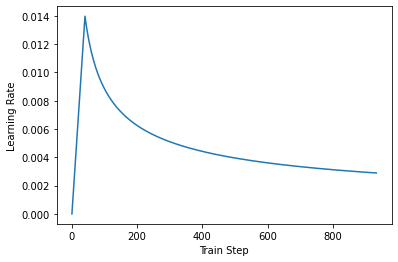

In [ ]:
d_model = 128
temp_learning_rate_schedule = CustomSchedule(d_model, warmup_steps=40)

plt.plot(temp_learning_rate_schedule(tf.range(len(X_train)//batch_size+1, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:
# for multi-output models
import keras.backend as K
from itertools import product
from functools import partial

# Custom loss function with costs
def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
    y_pred_max_mat = K.equal(y_pred, y_pred_max)
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):
        final_mask += (weights[c_t, c_p] * y_pred_max_mat[:, c_p] * y_true[:, c_t])
    return K.categorical_crossentropy(y_pred, y_true) * final_mask

loss_cust = partial(w_categorical_crossentropy, weights=class_weights)

In [ ]:
epochs = 100
# Optimizer 1
# learning_rate = CustomSchedule(d_model, warmup_steps=40)
# optimizer = tf.keras.optimizers.Adam(learning_rate)

# Optimizer 2
#!pip install -q tf-models-official
#from official.nlp import optimization
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
#num_train_steps = steps_per_epoch * epochs
#num_warmup_steps = int(0.1*num_train_steps)
#init_lr = 3e-5
#optimizer = optimization.create_optimizer(init_lr=init_lr,  # try custom lr_scheduler, see translator transformer
#                                          num_train_steps=num_train_steps,
#                                          num_warmup_steps=num_warmup_steps,
#                                          optimizer_type='adamw')

# Simple Optimizer
optimizer = tf.keras.optimizers.Adam(1e-3)

# Simple loss
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)  # get probabilities if False, otherwise logits

# Custom loss: loss_cust
# Custom loss stackoverflow
# loss = class_loss(list(class_weights.values()))
# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

model.compile(optimizer=optimizer, loss=loss, metrics=metrics) # {k: class_loss(v) for k, v in class_weights.items()}

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               18432     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 8)                 5

In [ ]:
import math

# labels_dict : {ind_label: count_label}
# mu : parameter to tune 

def create_class_weight(labels_dict,mu=0.15):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    
    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0
    
    return class_weight

class_weights = create_class_weight(y_train.value_counts().to_dict())

In [ ]:
class_weights = {k-1: v for k,v in class_weights.items()}
history = model.fit(train_ds, 
                    epochs=epochs, 
                    verbose=2, 
                    callbacks=callbacks,
                    validation_data=val_ds,
                    class_weight=class_weights,
                    steps_per_epoch=steps_per_epoch
                    )

Epoch 1/100
818/818 - 3s - loss: 1.8299 - f1_score: 0.3213 - val_loss: 1.5844 - val_f1_score: 0.3967 - lr: 0.0010 - 3s/epoch - 4ms/step
Epoch 2/100
818/818 - 2s - loss: 1.7036 - f1_score: 0.3741 - val_loss: 1.5032 - val_f1_score: 0.4110 - lr: 0.0010 - 2s/epoch - 3ms/step
Epoch 3/100
818/818 - 2s - loss: 1.6482 - f1_score: 0.4050 - val_loss: 1.4621 - val_f1_score: 0.4446 - lr: 0.0010 - 2s/epoch - 3ms/step
Epoch 4/100
818/818 - 2s - loss: 1.6217 - f1_score: 0.4167 - val_loss: 1.4466 - val_f1_score: 0.4480 - lr: 0.0010 - 2s/epoch - 3ms/step
Epoch 5/100
818/818 - 2s - loss: 1.6061 - f1_score: 0.4260 - val_loss: 1.4289 - val_f1_score: 0.4570 - lr: 0.0010 - 2s/epoch - 3ms/step
Epoch 6/100
818/818 - 2s - loss: 1.5949 - f1_score: 0.4258 - val_loss: 1.4281 - val_f1_score: 0.4524 - lr: 0.0010 - 2s/epoch - 3ms/step
Epoch 7/100
818/818 - 2s - loss: 1.5821 - f1_score: 0.4301 - val_loss: 1.4147 - val_f1_score: 0.4574 - lr: 0.0010 - 2s/epoch - 3ms/step
Epoch 8/100
818/818 - 2s - loss: 1.5745 - f1_sco

In [ ]:
model.evaluate(test_ds)  
# [1.3680638074874878, 0.4952624440193176] with Lr imputation, median, near=25, weights - log, ascending order

390/390 [==============================] - 1s 2ms/step - loss: 1.3700 - f1_score: 0.4917


[1.3700264692306519, 0.49167293310165405]

In [ ]:
final_preds_nn = model.predict(test)
final_preds_nn = np.argmax(final_preds_nn, axis=1) + 1
sub_nn = pd.DataFrame(np.stack((tt, final_preds_nn), axis=1), columns=['Id', TARGET_NAME])
sub_nn.to_csv(data_sub_root, index=False, encoding='utf-8')
sub_nn.head()

,Id,Response
0,1,4
1,2,6
2,3,7
3,4,2
4,5,8


In [ ]:
class_weights = compute_class_weight(class_weight='balanced', classes=y_train.unique(), y=y_train)
#class_weights = dict(zip(np.arange(8), class_weights))
class_weights = dict(zip(y_train.value_counts().index, class_weights))
class_weights

{0: 1.3829511834319526,
 1: 0.9199261992619926,
 2: 7.390316205533597,
 3: 1.1212893553223389,
 4: 5.122602739726028,
 5: 0.38275332650972366,
 6: 0.6569747013352073,
 7: 1.2008670520231215}

In [ ]:
df = pd.read_csv(data_train_root)
for column in df.columns:
    per = 100 * df[column].isna().sum() / df.shape[0]
    if per != 0:
        print(f'{column}: {per:.2f}% missing,', 'to drop or add new category' if per >=50 else 'try to impute or predict')

Employment_Info_1: 0.04% missing, try to impute or predict
Employment_Info_4: 11.61% missing, try to impute or predict
Employment_Info_6: 18.15% missing, try to impute or predict
Insurance_History_5: 42.89% missing, try to impute or predict
Family_Hist_2: 48.45% missing, try to impute or predict
Family_Hist_3: 57.48% missing, to drop or add new category
Family_Hist_4: 32.30% missing, try to impute or predict
Family_Hist_5: 70.44% missing, to drop or add new category
Medical_History_1: 14.80% missing, try to impute or predict
Medical_History_10: 99.07% missing, to drop or add new category
Medical_History_15: 75.09% missing, to drop or add new category
Medical_History_24: 93.59% missing, to drop or add new category
Medical_History_32: 98.13% missing, to drop or add new category


In [ ]:
# HAND
# trying iterative imputer with another regressor, strategy and correlated neighbors

# load, clean and split data in advance!

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor  # 'reg:squarederror'

# use LinearRegression as xgb estimates slowly! RAM is over
prep_pipeline = make_pipeline(ce.CatBoostEncoder(random_state=1), 
                              IterativeImputer(estimator=LinearRegression(), 
                                               initial_strategy='median', 
                                               n_nearest_features=25,
                                               imputation_order='ascending',
                                               random_state=1),
                              MinMaxScaler(),)
X_train = prep_pipeline.fit_transform(X_train, y_train)
X_test = prep_pipeline.transform(X_test)


X_train = pd.DataFrame(X_train, columns=X.columns.to_list())
X_test = pd.DataFrame(X_test, columns=X.columns.to_list())

lda = LDA(n_components=5)
columns = [column for column in X_train.columns if column.startswith('Medical_History')]
else_columns = [column for column in X_train.columns if column not in columns]
lda_columns = [f'lda_{i+1}' for i in range(5)]
X_train_1 = X_train[else_columns]
X_test_1 = X_test[else_columns]

lda.fit(X_train[columns], y_train)
X_train_2 = lda.transform(X_train[columns])
X_test_2 = lda.transform(X_test[columns])

# Stacking results
X_train = np.hstack((X_train_1, X_train_2))
X_test = np.hstack((X_test_1, X_test_2))
X_test = pd.DataFrame(X_test, columns=else_columns+lda_columns)
X_train = pd.DataFrame(X_train, columns=else_columns+lda_columns)

# prepare test for prediction and submission
test = prep_pipeline.transform(test)
test = pd.DataFrame(test, columns=X.columns.to_list())
test_1 = test[else_columns]
test_2 = lda.transform(test[columns])
test = np.hstack((test_1, test_2))
test = pd.DataFrame(test, columns=else_columns+lda_columns)

In [ ]:
final_drop = ['Employment_Info_4',
 'Family_Hist_2',
 'Ht',
 'Insurance_History_5',
 'Insurance_History_7',
 'Insurance_History_8',
 'Insurance_History_9',
 'InsuredInfo_3',
 #'Medical_History_1',
 #'Medical_History_11',
 #'Medical_History_12',
 #'Medical_History_17',
 #'Medical_History_2',
 #'Medical_History_22',
 #'Medical_History_29',
 #'Medical_History_34',
 #'Medical_History_35',
 #'Medical_History_36',
 #'Medical_History_38',
 #'Medical_History_5',
 'Medical_Keyword_1',
 'Medical_Keyword_11',
 'Medical_Keyword_13',
 'Medical_Keyword_2',
 'Medical_Keyword_22',
 'Medical_Keyword_30',
 'Medical_Keyword_45',
 'Product_Info_1',
 'Product_Info_7',
 ]
# medical history stay if apply decomposition!

In [ ]:
train = pd.read_csv(data_train_root)
test = pd.read_csv(data_test_root)
train.set_index('Id', drop=True, inplace=True)
test.set_index('Id', drop=True, inplace=True)

columns_to_drop = []
for column in train.columns:
    per = 100 * train[column].isna().sum() / train.shape[0]
    if per != 0:
        if per >= 50:
            columns_to_drop.append(column)

final_drop = set(final_drop)
final_drop.update(set(columns_to_drop))
final_drop = list(final_drop)

xgb_cols = ['Medical_Keyword_32', 'Medical_Keyword_25',
            'Medical_History_11', 'Medical_Keyword_23', 'Medical_Keyword_15',
            'Medical_Keyword_16']

def clean(df, columns=xgb_cols, train=True):
    if train:
        df.drop_duplicates(inplace=True)
    #df.loc[df['Medical_History_1'] > 200, 'Medical_History_1'] = None # we will impute these outliers
    #df['MedicalSum'] = df[columns].sum(axis=1)
    #df = df.drop(columns, axis=1)
    #df = reduce_memory(df)
    return df

#train = clean(train)
#test = clean(test, train=False)

X, y = train.drop(TARGET_NAME, axis=1), train[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=1)
clear_output()

In [ ]:
# cleaning class
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion

class CleanUp(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = reduce_memory(X)
        clear_output()
        return X
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        X = self.transform(X, y)
        return X

class ColumnSelector(BaseEstimator, TransformerMixin):
    """Select only specified columns. Use in pipeline with column specific transformers"""
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]

In [ ]:
train = pd.read_csv(data_train_root)
test = pd.read_csv(data_test_root)
train.set_index('Id', drop=True, inplace=True)
test.set_index('Id', drop=True, inplace=True)
train.drop_duplicates(inplace=True)

X, y = train.drop(TARGET_NAME, axis=1), train[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=1)

In [ ]:
# for deep model or eval_set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1,  shuffle=True,
                                                      stratify=y_train, random_state=1)

In [ ]:
# for sklearn suitable models
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

num_cols = X_train.select_dtypes(exclude=['category', 'object']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['category', 'object']).columns.to_list()
dec_cols = [column for column in X_train.columns if column.startswith('Medical_History')]
dec_cols_2 = [column for column in X_train.columns if column.startswith('Medical_Keyword')]

numerical_transformer = Pipeline(steps=[('imputer', IterativeImputer(estimator=LinearRegression(), 
                                                                     initial_strategy='median', 
                                                                     n_nearest_features=35,
                                                                     imputation_order='ascending',
                                                                     random_state=1)),
                                         ('scaler', MinMaxScaler())])

# for encoder may use cycle to try encoders from ce
categorical_transformer = Pipeline(steps=[('cat_imputer', SimpleImputer(strategy='most_frequent')),
                                          ('encoder', ce.cat_boost.CatBoostEncoder(return_df=True, a=3))
                                          ])

decomposition = Pipeline(steps=[('imputer', IterativeImputer(estimator=LinearRegression(), 
                                                                     initial_strategy='median', 
                                                                     n_nearest_features=35,
                                                                     imputation_order='ascending',
                                                                     random_state=1)),
                                ('lda', LDA(n_components=5))])

pca = PCA(n_components=int(len(dec_cols) * 0.8), random_state=1)

# for target encoding use a 20-30%-sample from train set to fit in order to prevent overfitting
# preprocessor[1].fit(X_train_sample, y_train_sample)
preprocessor = ColumnTransformer(
    transformers=[
                ('num', numerical_transformer, num_cols),
                ('cat', categorical_transformer, cat_cols),
                ('dec', decomposition, dec_cols),  # decomment if not removing transformed columns
                #('pca', pca, dec_cols_2)
    ], remainder='passthrough')

kmeans = KMeans(n_clusters=8,
                n_init=30,
                random_state=1)

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import f1_score
from imblearn.pipeline import Pipeline as Imbpipe

def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label().ravel()
    y_pred = np.argmax(y_pred, axis=1) + 1
    # print(y_pred, y_pred.shape, y_true, y_true.shape)
    err = 1-f1_score(y_true, np.round(y_pred), average='weighted')
    return 'f1_err', err

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
class_weights = create_class_weight(y_train.value_counts().to_dict(), mu=0.3)

lgbm = LGBMClassifier(boosting_type='goss', 
                      num_leaves=31, 
                      max_depth=5, 
                      learning_rate=0.01, 
                      n_estimators=800, 
                      class_weight=None, 
                      objective='Multiclass',
                      subsample=.3, 
                      n_jobs=-1, 
                      colsample_bytree=0.5, 
                      is_unbalanced=True, 
                      random_state=1)

xb = XGBClassifier(max_depth=5, 
                   learning_rate=0.01, 
                   random_state=1, 
                   reg_lambda=100., 
                   colsample_bytree=0.7,
                   sample_weights=class_weights,
                   n_estimators=800,
                   subsample=.8,
                   objective='multi:softprob'
                   )

model_pipeline = Imbpipe(steps=[('starter', CleanUp()),
                                ('preprocessor', preprocessor),
                                ('next_imputer', IterativeImputer(random_state=1)),
                                ('smote', SMOTEENN(random_state=1)),  # here leeds to significant overfitting
                                ('extreme', xb)
                                ])

""" # steps for target encoder not to overfit
X_sample = X_train.sample(int(0.3 * len(X_train)), random_state=1)
indexes = X_sample.index
y_sample = y_train[indexes]
categorical_transformer.fit(X_sample, y_sample)
X_train = categorical_transformer.transform(X_train)
X_test = categorical_transformer.transform(X_test)
X_train.columns = X.columns
X_test.columns = X.columns
"""

# these steps are nessasary since we applying early_stopping_rounds, for eval better use valid data, not test
X_train_transformed = model_pipeline[:-2].fit_transform(X_train, y_train)
# X_train_transformed, y_train_sm = model_pipeline[-2].fit_resample(X_train_transformed, y_train)  # resampling
X_test_transformed = model_pipeline[:-2].transform(X_test)


""" kmeans distancies
X_train_cl = kmeans.fit_transform(pd.DataFrame(X_train_transformed).fillna(method='bfill'))
X_test_cl = kmeans.transform(pd.DataFrame(X_test_transformed).fillna(method='bfill'))
X_train_transformed = np.hstack([X_train_transformed, X_train_cl])
X_test_transformed = np.hstack([X_test_transformed, X_test_cl])
"""

fit_params = {'early_stopping_rounds': 3,  # extreme__early_stopping_rounds if not calling straightforward
              'eval_set': [(X_test_transformed, y_test)],  # X_valid, y_valid
              'eval_metric': None, #None, #f1_eval,  #'mlogloss'
              'verbose': False
}

model_pipeline[-1].fit(X_train_transformed, y_train, **fit_params)
xb_train_preds = model_pipeline[-1].predict(X_train_transformed)
xb_test_preds = model_pipeline[-1].predict(X_test_transformed)
report(y_train, xb_train_preds, y_test, xb_test_preds) # results after imputation by LinearRegression

Train
               precision    recall  f1-score   support

           1      0.437     0.144     0.217      3027
           2      0.455     0.249     0.322      3242
           3      0.694     0.346     0.461       492
           4      0.581     0.730     0.647       710
           5      0.567     0.561     0.564      2629
           6      0.452     0.531     0.488      5533
           7      0.481     0.276     0.351      3953
           8      0.628     0.912     0.744      9499

    accuracy                          0.554     29085
   macro avg      0.537     0.469     0.474     29085
weighted avg      0.530     0.554     0.517     29085

Test
               precision    recall  f1-score   support

           1      0.392     0.120     0.184      1298
           2      0.424     0.225     0.294      1389
           3      0.561     0.261     0.356       211
           4      0.560     0.737     0.636       304
           5      0.521     0.540     0.530      1127
           

In [ ]:
pca_pipe = Pipeline(steps=[('selector', ColumnSelector(dec_cols_2)),
                           ('imputer', IterativeImputer(random_state=1)),
                           ('pca', PCA(n_components=20, random_state=1))])

lda_pipe = Pipeline(steps=[('selector', ColumnSelector(dec_cols)),
                           ('imputer', IterativeImputer(random_state=1)),
                           ('lda', LDA(n_components=7))])

needed_cols = list(set(num_cols).union(set(cat_cols)).difference(set(dec_cols)).difference(set(dec_cols_2)))
cols_selector = ColumnSelector(needed_cols)

preprocessor = ColumnTransformer(
    transformers=[
                ('num', numerical_transformer, num_cols),
                ('cat', categorical_transformer, cat_cols),
    ], remainder='passthrough')

X_train_transformed = preprocessor.fit_transform(X_train, y_train)
X_test_transformed = preprocessor.transform(X_test)
X_train_transformed = pd.DataFrame(X_train_transformed, columns=X.columns.to_list())
X_test_transformed = pd.DataFrame(X_test_transformed, columns=X.columns.to_list())

dataset_union = FeatureUnion(transformer_list=[('selector', cols_selector),
                                               ('lda', lda_pipe),
                                               ('pca', pca_pipe),
                                              ])
y_to_train = y_train.copy()

X_train_transformed = dataset_union.fit_transform(X_train_transformed, y_to_train)
X_test_transformed = dataset_union.transform(X_test_transformed)

lgbm2 = LGBMClassifier(boosting_type='goss', 
                      num_leaves=31, 
                      max_depth=5, 
                      learning_rate=0.01, 
                      n_estimators=800, 
                      class_weight=None, 
                      objective='Multiclass',
                      subsample=.3, 
                      n_jobs=-1, 
                      colsample_bytree=0.5, 
                      is_unbalanced=True, 
                      random_state=1)

fit_params = {'early_stopping_rounds': 3,  
              'eval_set': [(X_test_transformed, y_test)], 
              'eval_metric': None, 
              'verbose': False
}

lgbm2.fit(X_train_transformed, y_train, **fit_params)
xb_train_preds = lgbm2.predict(X_train_transformed)
xb_test_preds = lgbm2.predict(X_test_transformed)
report(y_train, xb_train_preds, y_test, xb_test_preds)

Train
               precision    recall  f1-score   support

           1      0.650     0.375     0.475      3027
           2      0.628     0.371     0.467      3242
           3      0.827     0.602     0.696       492
           4      0.654     0.680     0.667       710
           5      0.682     0.591     0.634      2629
           6      0.521     0.571     0.544      5533
           7      0.532     0.406     0.461      3953
           8      0.667     0.910     0.769      9499

    accuracy                          0.622     29085
   macro avg      0.645     0.563     0.589     29085
weighted avg      0.618     0.622     0.604     29085

Test
               precision    recall  f1-score   support

           1      0.439     0.250     0.319      1298
           2      0.441     0.251     0.320      1389
           3      0.474     0.218     0.299       211
           4      0.492     0.539     0.515       304
           5      0.565     0.512     0.537      1127
           

In [ ]:
imp = model_pipeline[-1].get_booster().get_score(importance_type="gain")
idx = np.argsort(list(imp.values()))[::-1]
X_train.columns[idx]
# maybe sum all weak columns to 1

Index(['Product_Info_1', 'Employment_Info_6', 'Medical_History_1',
       'Product_Info_2', 'BMI', 'Insurance_History_3', 'Medical_History_4',
       'InsuredInfo_3', 'Insurance_History_4', 'Product_Info_5',
       ...
       'Medical_Keyword_11', 'Medical_History_27', 'Medical_Keyword_5',
       'Medical_History_15', 'Medical_Keyword_32', 'Medical_Keyword_25',
       'Medical_History_11', 'Medical_Keyword_23', 'Medical_Keyword_15',
       'Medical_Keyword_16'],
      dtype='object', length=111)

In [ ]:
X_train_transformed.shape[1], X_train.shape[1], len(num_cols) + len(cat_cols), X.shape[1]
#pd.DataFrame(X_train_transformed).isna().sum().sum()
model_pipeline[-1].__class__.__name__